# Assignment 2

### Group members: Luigi Cheng, ...

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Importing data

In [3]:
rows = []
max_rows = 200000

with open(r"C:\Users\holde\Github\Video_Games.jsonl", "r") as f:
    for i, line in enumerate(f):
        if i == max_rows:
            break
        rows.append(json.loads(line))

reviews = pd.DataFrame(rows)
reviews.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,4.0,It’s pretty sexual. Not my fav,I’m playing on ps5 and it’s interesting. It’s...,[],B07DJWBYKP,B07DK1H3H5,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1608186804795,0,True
1,5.0,Good. A bit slow,Nostalgic fun. A bit slow. I hope they don’t...,[],B00ZS80PC2,B07SRWRH5D,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1587051114941,1,False
2,5.0,... an order for my kids & they have really en...,This was an order for my kids & they have real...,[],B01FEHJYUU,B07MFMFW34,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,1490877431000,0,True
3,5.0,Great alt to pro controller,"These work great, They use batteries which is ...",[],B07GXJHRVK,B0BCHWZX95,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,1577637634017,0,True
4,5.0,solid product,I would recommend to anyone looking to add jus...,[],B00HUWA45W,B00HUWA45W,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,1427591932000,0,True


In [4]:
rows = []
max_rows = 200000

with open(r"C:\Users\holde\Github\meta_Video_Games.jsonl", "r") as f:
    for i, line in enumerate(f):
        if i == max_rows:
            break
        rows.append(json.loads(line))
        
meta = pd.DataFrame(rows)
print(meta.columns)
meta.head()

Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
      dtype='object')


,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Video Games,Dash 8-300 Professional Add-On,5.0,1,[Features Dash 8-300 and 8-Q300 ('Q' rollout l...,[The Dash 8-300 Professional Add-On lets you p...,None,[{'thumb': 'https://m.media-amazon.com/images/...,[],Aerosoft,"[Video Games, PC, Games]",{'Pricing': 'The strikethrough price is the Li...,B000FH0MHO,None,NaN,NaN
1,Video Games,Phantasmagoria: A Puzzle of Flesh,4.1,18,[Windows 95],[],None,[{'thumb': 'https://m.media-amazon.com/images/...,[],Sierra,"[Video Games, PC, Games]","{'Best Sellers Rank': {'Video Games': 137612, ...",B00069EVOG,None,NaN,NaN
2,Video Games,NBA 2K17 - Early Tip Off Edition - PlayStation 4,4.3,223,[The #1 rated NBA video game simulation series...,[Following the record-breaking launch of NBA 2...,58.0,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'NBA 2K17 - Kobe: Haters vs Players...,2K,"[Video Games, PlayStation 4, Games]","{'Release date': 'September 16, 2016', 'Best S...",B00Z9TLVK0,None,NaN,NaN
3,Video Games,Nintendo Selects: The Legend of Zelda Ocarina ...,4.9,22,[Authentic Nintendo Selects: The Legend of Zel...,[],37.42,[{'thumb': 'https://m.media-amazon.com/images/...,[],Amazon Renewed,"[Video Games, Legacy Systems, Nintendo Systems...","{'Best Sellers Rank': {'Video Games': 51019, '...",B07SZJZV88,None,NaN,NaN
4,Video Games,Thrustmaster Elite Fitness Pack for Nintendo Wii,3.0,3,"[Includes (9) Total Accessories, Pedometer, Wi...",[The Thrustmaster Motion Plus Elite Fitness Pa...,None,[{'thumb': 'https://m.media-amazon.com/images/...,[],THRUSTMASTER,"[Video Games, Legacy Systems, Nintendo Systems...","{'Release date': 'November 1, 2009', 'Pricing'...",B002WH4ZJG,None,NaN,NaN


## Identify tasks

	•	Predicting 1–5 rating from review text and metadata
	•	linear models, TF-IDF, regularization, baselines, evaluation
	•	Models: ridge regression or logistic regression
	•	Evaluation: RMSE
	•	Baselines: global mean, item mean, user mean, TF-IDF-only
	•	Validation:
        •	residual checks
        •	predicted vs true rating distribution
        •	group-level performance (verified vs unverified)

## Exploratory Data Analysis

## Reviews data

In [5]:
sns.set(style="whitegrid")

reviews = reviews.copy()
reviews = reviews.dropna(subset=['rating', 'text'])

# Adding features
reviews['timestamp'] = pd.to_datetime(reviews['timestamp'], unit='ms', errors='coerce')
reviews['year'] = reviews['timestamp'].dt.year
reviews['review_length'] = reviews['text'].astype(str).apply(len)

print("REVIEWS SHAPE:", reviews.shape)
print("\nReviews columns:", reviews.columns.tolist())

REVIEWS SHAPE: (200000, 12)

Reviews columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'year', 'review_length']


In [6]:
print("Missing values in reviews:")
reviews.isnull().sum()

Missing values in reviews:


rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
year                 0
review_length        0
dtype: int64

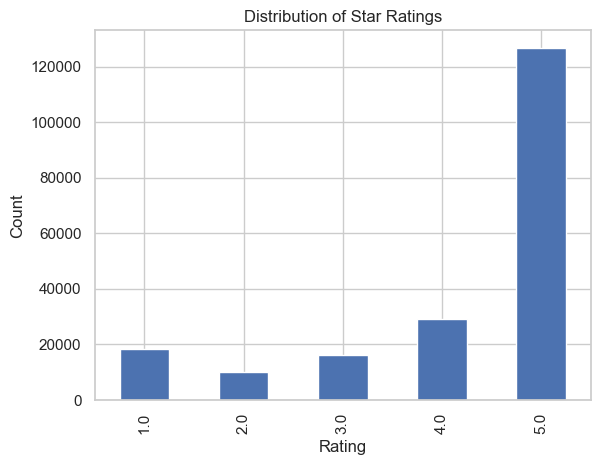

In [7]:
reviews['rating'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Star Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

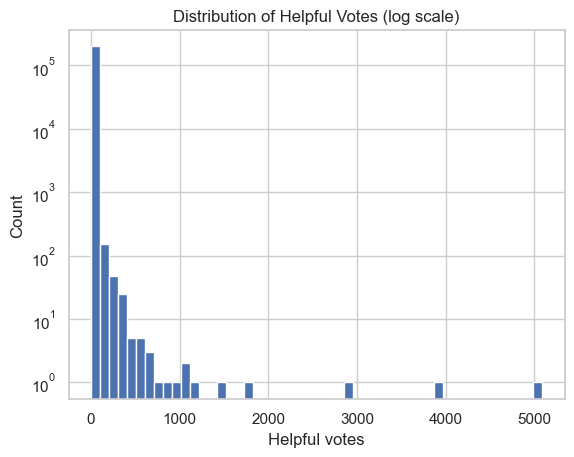

In [8]:
reviews['helpful_vote'].hist(bins=50)
plt.yscale('log')
plt.title("Distribution of Helpful Votes (log scale)")
plt.xlabel("Helpful votes")
plt.ylabel("Count")
plt.show()

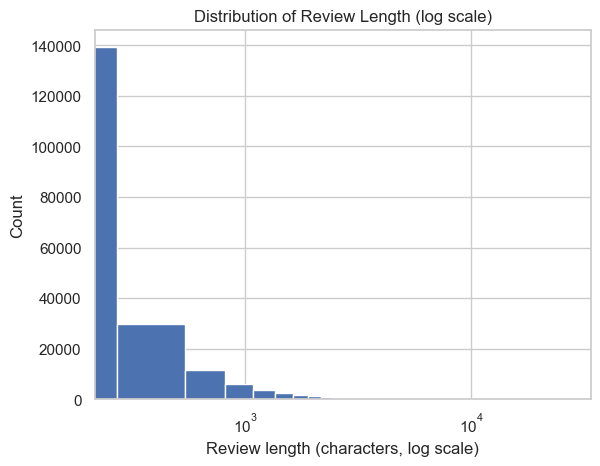

In [9]:
plt.hist(reviews['review_length'], bins=100)
plt.xscale('log')
plt.title("Distribution of Review Length (log scale)")
plt.xlabel("Review length (characters, log scale)")
plt.ylabel("Count")
plt.show()

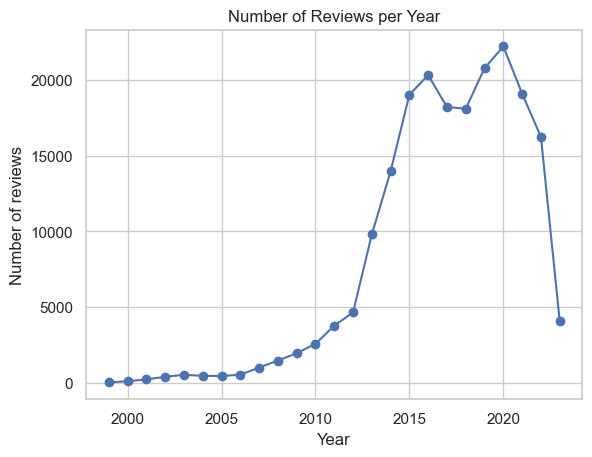

In [10]:
if reviews['year'].notnull().any():
    reviews['year'].value_counts().sort_index().plot(kind='line', marker='o')
    plt.title("Number of Reviews per Year")
    plt.xlabel("Year")
    plt.ylabel("Number of reviews")
    plt.show()

In [11]:
print("Rating describe:")
reviews['rating'].describe()

Rating describe:


count    200000.000000
mean          4.180115
std           1.304765
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [12]:
print("Helpful votes describe:")
reviews['helpful_vote'].describe()

Helpful votes describe:


count    200000.000000
mean          1.392010
std          19.601652
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        5085.000000
Name: helpful_vote, dtype: float64

In [13]:
print("Review length describe:")
reviews['review_length'].describe()

Review length describe:


count    200000.000000
mean        335.377740
std         675.454936
min           0.000000
25%          46.000000
50%         134.000000
75%         338.000000
max       27014.000000
Name: review_length, dtype: float64

In [14]:
print("Verified purchase counts:")
reviews['verified_purchase'].value_counts()

Verified purchase counts:


verified_purchase
True     171773
False     28227
Name: count, dtype: int64

In [15]:
helpful_by_rating_mean = reviews.groupby('rating')['helpful_vote'].mean()
print("Mean helpful votes by rating:")
helpful_by_rating_mean

Mean helpful votes by rating:


rating
1.0    3.137578
2.0    2.208858
3.0    1.594014
4.0    1.490747
5.0    1.028289
Name: helpful_vote, dtype: float64

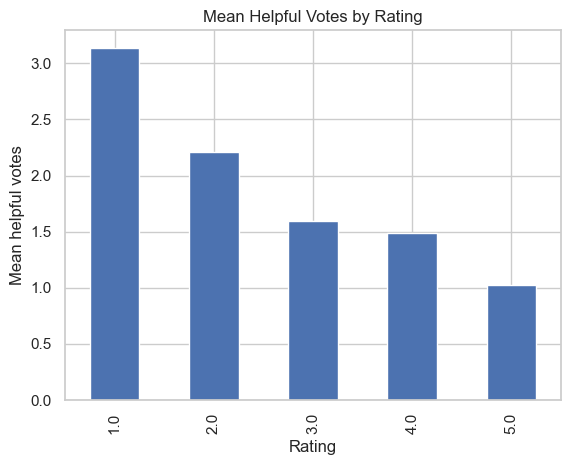

In [16]:
helpful_by_rating_mean.plot(kind='bar')
plt.title("Mean Helpful Votes by Rating")
plt.xlabel("Rating")
plt.ylabel("Mean helpful votes")
plt.show()

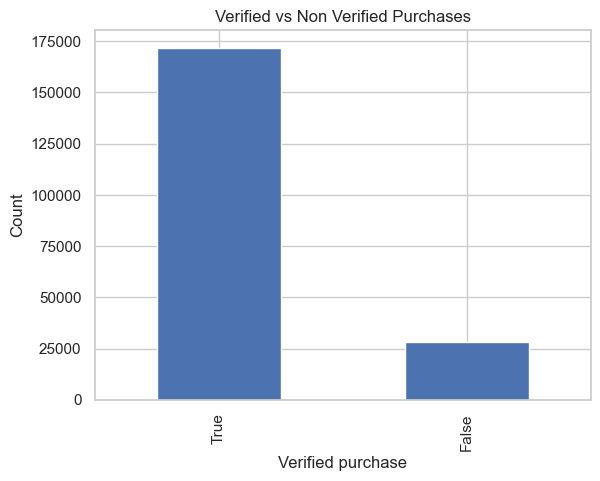

In [17]:
reviews['verified_purchase'].value_counts().plot(kind='bar')
plt.title("Verified vs Non Verified Purchases")
plt.xlabel("Verified purchase")
plt.ylabel("Count")
plt.show()

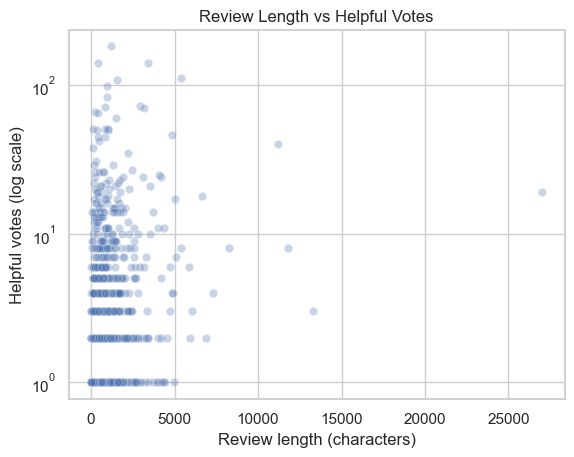

In [18]:
sample_for_scatter = reviews.sample(min(5000, len(reviews)), random_state=0)
sns.scatterplot(
    data=sample_for_scatter,
    x='review_length',
    y='helpful_vote',
    alpha=0.3
)
plt.yscale('log')
plt.title("Review Length vs Helpful Votes")
plt.xlabel("Review length (characters)")
plt.ylabel("Helpful votes (log scale)")
plt.show()

In [19]:
top_games = (
    reviews.groupby('parent_asin')
           .agg(review_count=('asin', 'count'),
                median_helpful=('helpful_vote', 'median'))
           .sort_values('review_count', ascending=False)
           .head(20)
)

meta_key = meta[['parent_asin', 'title', 'price']].drop_duplicates()

top_games = top_games.reset_index().merge(
    meta_key,
    on='parent_asin',
    how='left'
)

print("Top 20 most reviewed games:")
top_games

Top 20 most reviewed games:


,parent_asin,review_count,median_helpful,title,price
0,B0BCHWZX95,1087,0.0,PowerA Enhanced Wireless Controller for Ninten...,67.61
1,B01N3ASPNV,779,0.0,amFilm Tempered Glass Screen Protector for Nin...,8.91
2,B07SRWRH5D,764,1.0,Final Fantasy VII: Remake - PlayStation 4,25.95
3,B077GG9D5D,744,0.0,DualShock 4 Wireless Controller for PlayStatio...,57.0
4,B000N5Z2L4,571,0.0,Xbox Live Gold: 1 Month Membership [Digital Code],9.99
5,B0BN942894,503,0.0,"BENGOO Stereo Pro Gaming Headset for PS4, PC, ...",33.99
6,B00HBUOVIO,444,0.0,"Ferrero Rocher, Premium Gourmet Milk Chocolate...",10.49
7,B07YBXFDYN,430,0.0,Skyrim VR - PlayStation 4,39.89
8,B004RMK5QG,429,0.0,PlayStation Plus: 12 Month Membership [Digital...,None
9,B07YBWT3PK,424,0.0,Fallout 4 - Xbox One,8.16


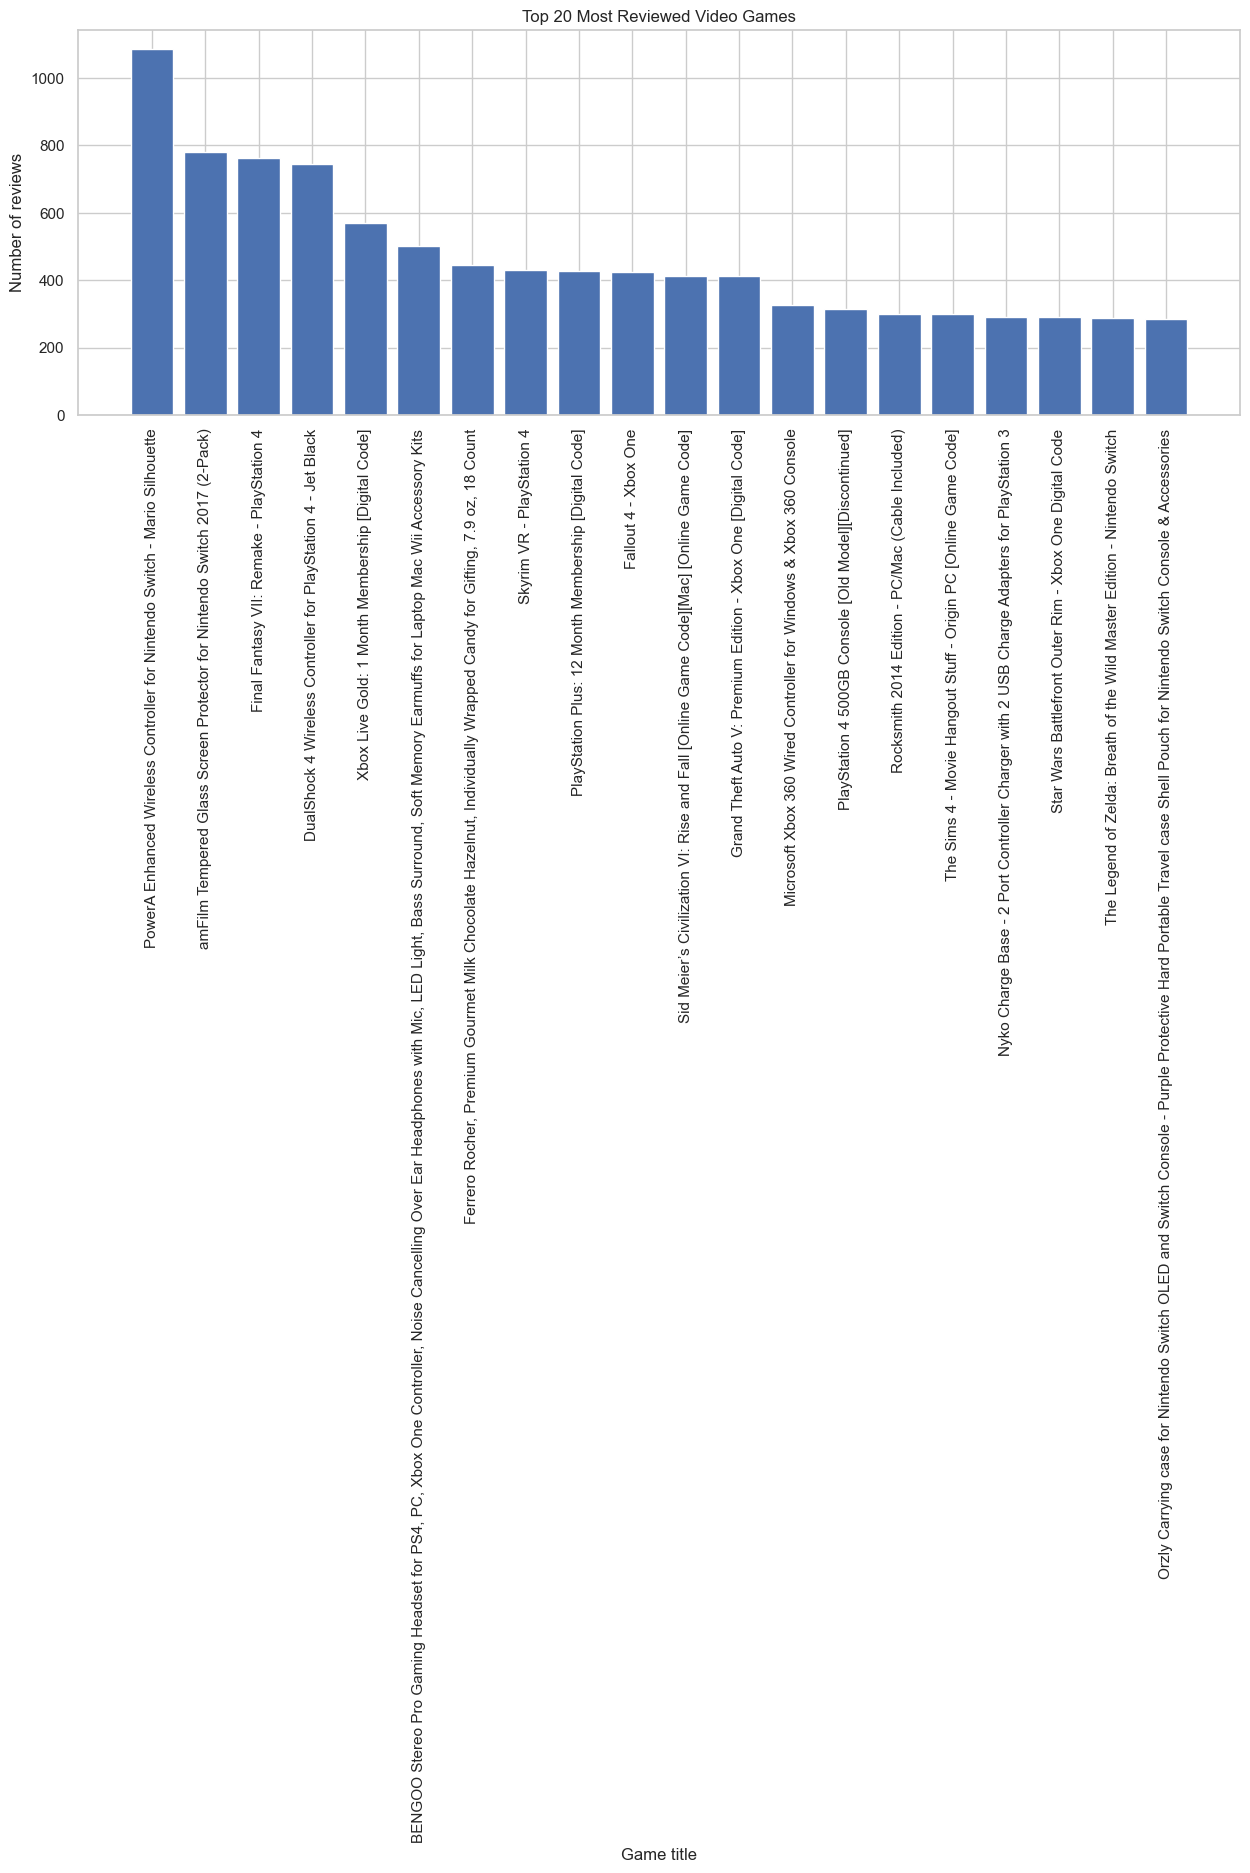

In [20]:
plt.figure(figsize=(15,5))
plt.bar(top_games['title'].fillna(top_games['parent_asin']).astype(str),
        top_games['review_count'])
plt.title("Top 20 Most Reviewed Video Games")
plt.xlabel("Game title")
plt.ylabel("Number of reviews")
plt.xticks(rotation=90)
plt.show()

## Meta data

In [21]:
meta = meta.copy()

print("META SHAPE:", meta.shape)
print("\nMeta columns:", meta.columns.tolist())

META SHAPE: (137269, 16)

Meta columns: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author']


In [22]:
print("Missing values in meta:")
meta.isnull().sum()

Missing values in meta:


main_category       11035
title                   0
average_rating          0
rating_number           0
features                0
description             0
price               75261
images                  0
videos                  0
store                4361
categories              0
details                 0
parent_asin             0
bought_together    137269
subtitle           136919
author             137007
dtype: int64

Since over half the metadata rows are missing price information and the price variable is not essential for predicting user ratings, I exclude price from the modeling features. Keeping it would require heavy imputation, which might introduce bias and reduce model reliability.

In [23]:
numeric_cols = []
for col in ['average_rating', 'rating_number']:
    if col in meta.columns:
        numeric_cols.append(col)

print("Numeric columns in meta:", numeric_cols)
meta[numeric_cols].describe()

Numeric columns in meta: ['average_rating', 'rating_number']


,average_rating,rating_number
count,137269.000000,137269.000000
mean,3.995296,244.305087
std,0.769537,2093.887043
min,1.000000,1.000000
25%,3.600000,5.000000
50%,4.100000,21.000000
75%,4.500000,87.000000
max,5.000000,278574.000000


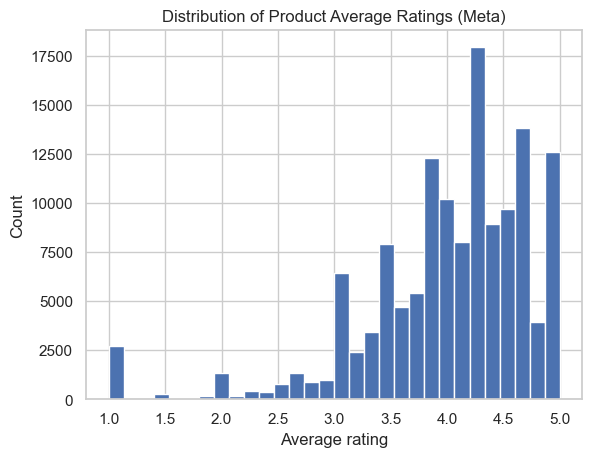

In [24]:
if 'average_rating' in meta.columns:
    meta['average_rating'].dropna().hist(bins=30)
    plt.title("Distribution of Product Average Ratings (Meta)")
    plt.xlabel("Average rating")
    plt.ylabel("Count")
    plt.show()

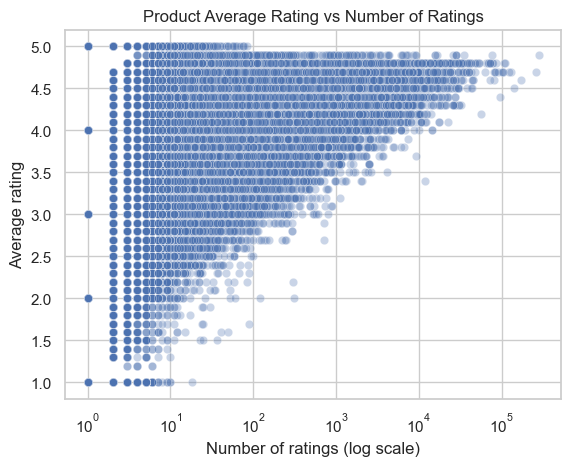

In [25]:
if set(['average_rating', 'rating_number']).issubset(meta.columns):
    sns.scatterplot(
        data=meta.dropna(subset=['average_rating', 'rating_number']),
        x='rating_number',
        y='average_rating',
        alpha=0.3
    )
    plt.xscale('log')
    plt.title("Product Average Rating vs Number of Ratings")
    plt.xlabel("Number of ratings (log scale)")
    plt.ylabel("Average rating")
    plt.show()

# Modeling

## Preprocessing 

In [26]:
reviews_model = reviews.copy()
meta_model = meta.copy()

# log because of skewness
reviews_model['log_helpful'] = np.log1p(reviews_model['helpful_vote'])
reviews_model['verified_purchase_int'] = reviews_model['verified_purchase'].astype(int)

In [27]:
# Merge
meta_small = meta_model[['parent_asin', 'average_rating', 'rating_number']].drop_duplicates()
df_all = reviews_model.merge(meta_small, on='parent_asin', how='left')

df_all.head(1)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,year,review_length,log_helpful,verified_purchase_int,average_rating,rating_number
0,4.0,It’s pretty sexual. Not my fav,I’m playing on ps5 and it’s interesting. It’s...,[],B07DJWBYKP,B07DK1H3H5,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2020-12-17 06:33:24.795,0,True,2020,226,0.0,1,4.1,2015


In [28]:
# Fill missing values
df_all['rating_number'] = df_all['rating_number'].fillna(0)
df_all['log_rating_number'] = np.log1p(df_all['rating_number'])
global_avg_rating_product = df_all['average_rating'].mean()
df_all['average_rating'] = df_all['average_rating'].fillna(global_avg_rating_product)

# Drop rows with missing rating or text
df_all = df_all.dropna(subset=['rating', 'text'])

print("df_all shape:", df_all.shape)
print("df_all columns:", df_all.columns.tolist()[:20])

df_all shape: (200000, 17)
df_all columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'year', 'review_length', 'log_helpful', 'verified_purchase_int', 'average_rating', 'rating_number', 'log_rating_number']


## Train/Validation/Test Split

In [29]:
#Modified the split from 81/9/10 to 80/10/10
train_val, test = train_test_split(
    df_all,
    test_size=0.1,
    random_state=1
)

train, val = train_test_split(
    train_val,
    test_size=1/9,
    random_state=1
)

y_train = train['rating']
y_val = val['rating']
y_test = test['rating']

print("Train size:", len(train))
print("Validation size:", len(val))
print("Test size:", len(test))

Train size: 160000
Validation size: 20000
Test size: 20000


## Baselines

In [30]:
def rmse(y, y_hat):
    return np.sqrt(mean_squared_error(y, y_hat))

In [31]:
global_mean = y_train.mean()

val_pred_global = np.full(len(val), global_mean)
test_pred_global = np.full(len(test), global_mean)

print("Global mean rating RMSE (val):", rmse(y_val, val_pred_global))
print("Global mean rating RMSE (test):", rmse(y_test, test_pred_global))

Global mean rating RMSE (val): 1.3003937060079152
Global mean rating RMSE (test): 1.2999433749686946


In [32]:
item_mean = train.groupby('parent_asin')['rating'].mean()

def predict_item_mean(df):
    return df['parent_asin'].map(item_mean).fillna(global_mean)

val_pred_item = predict_item_mean(val)
test_pred_item = predict_item_mean(test)

print("Item mean rating RMSE (val):", rmse(y_val, val_pred_item))
print("Item mean rating RMSE (test):", rmse(y_test, test_pred_item))

Item mean rating RMSE (val): 1.3417882366719993
Item mean rating RMSE (test): 1.3436834565062403


In [33]:
user_mean = train.groupby('user_id')['rating'].mean()

def predict_user_mean(df):
    return df['user_id'].map(user_mean).fillna(global_mean)

val_pred_user = predict_user_mean(val)
test_pred_user = predict_user_mean(test)

print("User mean rating RMSE (val):", rmse(y_val, val_pred_user))
print("User mean rating RMSE (test):", rmse(y_test, test_pred_user))

User mean rating RMSE (val): 1.327556576454052
User mean rating RMSE (test): 1.3267370562760097


## Linear regression (Baseline)

In [34]:
metadata_features = [
    'review_length',
    'log_helpful',
    'verified_purchase_int',
    'average_rating',
    'log_rating_number',
]

X_train_meta = train[metadata_features]
X_val_meta = val[metadata_features]
X_test_meta = test[metadata_features]

meta_model_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

meta_model_lr.fit(X_train_meta, y_train)

val_pred_meta = meta_model_lr.predict(X_val_meta)
test_pred_meta = meta_model_lr.predict(X_test_meta)


print("Validation RMSE:", rmse(y_val, val_pred_meta))
print("Test RMSE:", rmse(y_test, test_pred_meta))

Validation RMSE: 1.24791883392477
Test RMSE: 1.2529676725712504


## Text-only model (TF-IDF + Ridge)

In [35]:
text_model = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=70000,
        ngram_range=(1, 2),
        min_df=3
    )),
    ('ridge', Ridge(alpha=1.0))
])

text_model.fit(train['text'], y_train,)

val_pred_text = text_model.predict(val['text'])
test_pred_text = text_model.predict(test['text'])

print("Validation RMSE:", rmse(y_val, val_pred_text))
print("Test RMSE:", rmse(y_test, test_pred_text))


Validation RMSE: 0.8015524435769018
Test RMSE: 0.7982997389981523


## Cutoff model 

In [36]:
from sklearn.base import clone
import numpy as np
import pandas as pd

cutoffs = [
    train['review_length'].quantile(0.3),
    train['review_length'].quantile(0.5), 
    train['review_length'].quantile(0.7),
    100,
    200
]

best_rmse = float('inf')
best_cutoff = None

for c in cutoffs:
    c = int(c)
    print(f"\n=== Trying cutoff = {c} ===")

    # masks
    short_train_mask = train['review_length'] <= c
    long_train_mask  = ~short_train_mask
    short_val_mask   = val['review_length'] <= c
    long_val_mask    = ~short_val_mask

    short_model = clone(text_model)
    long_model  = clone(text_model)

    short_model.fit(train.loc[short_train_mask, 'text'],
                    y_train[short_train_mask])
    long_model.fit(train.loc[long_train_mask, 'text'],
                   y_train[long_train_mask])

    # combine predictions
    val_pred_seg = pd.Series(index=val.index, dtype=float)
    val_pred_seg[short_val_mask] = short_model.predict(
        val.loc[short_val_mask, 'text']
    )
    val_pred_seg[long_val_mask] = long_model.predict(
        val.loc[long_val_mask, 'text']
    )

    score = rmse(y_val, val_pred_seg.values)
    print("val RMSE:", score)

    if score < best_rmse:
        best_rmse = score
        best_cutoff = c

print("\nBest cutoff:", best_cutoff, "with val RMSE:", best_rmse)



=== Trying cutoff = 60 ===
val RMSE: 0.8032662326986602

=== Trying cutoff = 134 ===
val RMSE: 0.8048242867980212

=== Trying cutoff = 273 ===
val RMSE: 0.8037003043088302

=== Trying cutoff = 100 ===
val RMSE: 0.8046404649935538

=== Trying cutoff = 200 ===
val RMSE: 0.8053577319186396

Best cutoff: 60 with val RMSE: 0.8032662326986602


In [ ]:
from sklearn.base import clone
import pandas as pd
import numpy as np

print("Using best cutoff:", 60)

# masks for best cutoff
short_train_mask = train['review_length'] <= 60
long_train_mask  = ~short_train_mask

short_val_mask = val['review_length'] <= 60
long_val_mask  = ~short_val_mask

short_test_mask = test['review_length'] <= 60
long_test_mask  = ~short_test_mask

short_model = clone(text_model)
long_model  = clone(text_model)

short_model.fit(train.loc[short_train_mask, 'text'],
                y_train[short_train_mask])
long_model.fit(train.loc[long_train_mask, 'text'],
               y_train[long_train_mask])

val_pred_seg  = pd.Series(index=val.index,  dtype=float)
test_pred_seg = pd.Series(index=test.index, dtype=float)

val_pred_seg[short_val_mask]   = short_model.predict(val.loc[short_val_mask, 'text'])
test_pred_seg[short_test_mask] = short_model.predict(test.loc[short_test_mask, 'text'])

val_pred_seg[long_val_mask]    = long_model.predict(val.loc[long_val_mask, 'text'])
test_pred_seg[long_test_mask]  = long_model.predict(test.loc[long_test_mask, 'text'])

print("Segmented val RMSE:", rmse(y_val,  val_pred_seg.values))
print("Segmented test RMSE:", rmse(y_test, test_pred_seg.values))


Using best cutoff: 60
Segmented val RMSE: 0.8032662326986602
Segmented test RMSE: 0.8013688297492637


In [38]:

# configs = [
#     {"max_features": 30000, "min_df": 5},
#     {"max_features": 30000, "min_df": 3},
#     {"max_features": 30000, "min_df": 2},
#     {"max_features": 50000, "min_df": 5},
#     {"max_features": 50000, "min_df": 3},
#     {"max_features": 50000, "min_df": 2},
#     {"max_features": 70000, "min_df": 5},
#     {"max_features": 70000, "min_df": 3},
#     {"max_features": 70000, "min_df": 2}
# ]

# best_val_rmse = float("inf")
# best_test_rmse = float("inf")
# best_cfg = None


# for cfg in configs:       
#     text_model_try = Pipeline([
#         ("tfidf", TfidfVectorizer(
#             max_features=cfg["max_features"],
#             ngram_range=(1, 2), 
#             min_df=cfg["min_df"]
#         )),
#         ("ridge", Ridge(alpha=1.0))
#     ])

#     text_model_try.fit(train["text"], y_train)
#     val_pred = text_model_try.predict(val["text"])
#     val_test = text_model_try.predict(test['text'])
#     score_val = rmse(y_val, val_pred)
#     score_test = rmse(y_test, val_test)

#     print("  current val RMSE: ", score_val)
#     print("  current test RMSE:", score_test)

#     if score_val < best_val_rmse:
#         best_val_rmse  = score_val
#         best_test_rmse = score_test
#         best_cfg = cfg

# print("\nBest TF-IDF config:", best_cfg)
# print("  best val RMSE: ", best_val_rmse)
# print("  test RMSE for that config:", best_test_rmse)

## TF-IDF + Ridge + Metadata

In [39]:
# same list
numeric_features = metadata_features  

preprocess = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(
            max_features=70000,
            ngram_range=(1, 2),
            min_df=3
        ), 'text'),
        ('num', StandardScaler(), numeric_features)
    ]
)
full_model = Pipeline([
    ('preprocess', preprocess),
    ('ridge', Ridge(alpha=1.0))
])

full_model.fit(train[['text'] + numeric_features], y_train)

val_pred_full = full_model.predict(val[['text'] + numeric_features])
test_pred_full = full_model.predict(test[['text'] + numeric_features])

print("Validation RMSE:", rmse(y_val, val_pred_full))
print("Test RMSE:", rmse(y_test, test_pred_full))

Validation RMSE: 0.7952042833179713
Test RMSE: 0.7908203877464697


## Blend Cutoff + (TF-IDf + Ridge + Metadata)

In [40]:
import numpy as np

weights = np.linspace(0.0, 1.0, 21)  # w on segmented model
best_w = None
best_rmse = float('inf')

for w in weights:
    val_blend = w * val_pred_seg + (1 - w) * val_pred_full
    val_blend_clip = np.clip(val_blend, 1.0, 5.0)

    score = rmse(y_val, val_blend_clip)
    print(f"w={w:.1f} -> val RMSE={score:.6f}")

    if score < best_rmse:
        best_rmse = score
        best_w = w

print("\nBest weight on segmented model:", best_w)
print("Best blended val RMSE:", best_rmse)

val_blend_best  = best_w * val_pred_seg + (1 - best_w) * val_pred_full
val_blend_best_clip = np.clip(val_blend_best, 1.0, 5.0)

test_blend  = best_w * test_pred_seg + (1 - best_w) * test_pred_full
test_blend_clip = np.clip(test_blend, 1.0, 5.0)

print("Blended test RMSE:", rmse(y_test, test_blend_clip))


w=0.0 -> val RMSE=0.777665
w=0.1 -> val RMSE=0.776643
w=0.1 -> val RMSE=0.775760
w=0.2 -> val RMSE=0.775017
w=0.2 -> val RMSE=0.774417
w=0.2 -> val RMSE=0.773966
w=0.3 -> val RMSE=0.773664
w=0.4 -> val RMSE=0.773511
w=0.4 -> val RMSE=0.773508
w=0.5 -> val RMSE=0.773656
w=0.5 -> val RMSE=0.773952
w=0.6 -> val RMSE=0.774401
w=0.6 -> val RMSE=0.775002
w=0.7 -> val RMSE=0.775754
w=0.7 -> val RMSE=0.776650
w=0.8 -> val RMSE=0.777695
w=0.8 -> val RMSE=0.778887
w=0.9 -> val RMSE=0.780222
w=0.9 -> val RMSE=0.781702
w=1.0 -> val RMSE=0.783319
w=1.0 -> val RMSE=0.785067

Best weight on segmented model: 0.4
Best blended val RMSE: 0.773508041697485
Blended test RMSE: 0.7694728995681951


In [41]:
print("Summary RMSE on validation set")
print("Global mean:           ", rmse(y_val, val_pred_global))
print("Item mean:             ", rmse(y_val, val_pred_item))
print("User mean:             ", rmse(y_val, val_pred_user))
print("LinReg:                ", rmse(y_val, val_pred_meta))
print("Text-only Ridge:       ", rmse(y_val, val_pred_text))
print("Text + metadata Ridge: ", rmse(y_val, val_pred_full))
print("Blend Cutoff + (Text + metadata ridege): ", rmse(y_val, val_blend_best_clip))

Summary RMSE on validation set
Global mean:            1.3003937060079152
Item mean:              1.3417882366719993
User mean:              1.327556576454052
LinReg:                 1.24791883392477
Text-only Ridge:        0.8015524435769018
Text + metadata Ridge:  0.7952042833179713
Blend Cutoff + (Text + metadata ridege):  0.773508041697485


In [42]:
results = pd.DataFrame({
    "Model": [
        "Global mean",
        "Item mean",
        "User mean",
        "Linear regression (metadata)",
        "Text-only Ridge",
        "Text + metadata Ridge",
        "Blend Cutoff + (Text + metadata + Ridge)"
    ],
    "Val RMSE": [
        rmse(y_val, val_pred_global),
        rmse(y_val, val_pred_item),
        rmse(y_val, val_pred_user),
        rmse(y_val, val_pred_meta),
        rmse(y_val, val_pred_text),
        rmse(y_val, val_pred_full),
        rmse(y_val, val_blend_best_clip),
    ]
})

results = results.sort_values("Val RMSE").reset_index(drop=True)
print(results.shape)

(7, 2)


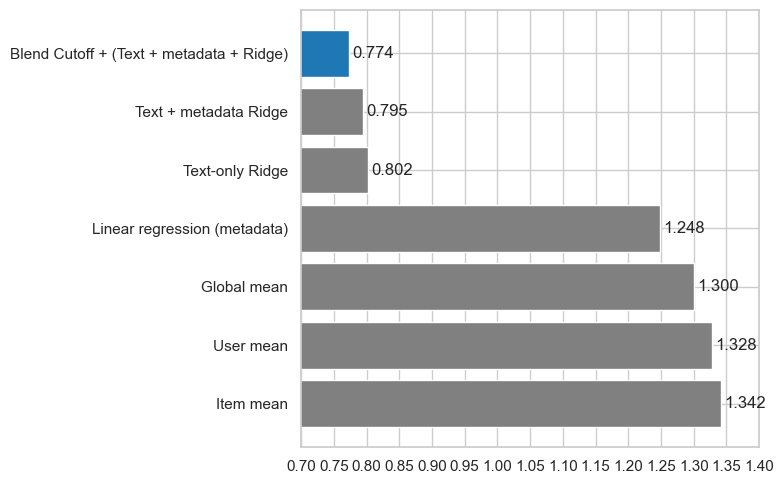

In [48]:
models   = results["Model"].tolist()
val_rmse = results["Val RMSE"].values
best_idx = 0  

plt.figure(figsize=(8, 5))

colors = ["grey"] * len(models)
colors[best_idx] = "tab:blue"   

y_pos = np.arange(len(models))
plt.barh(y_pos, val_rmse, color=colors)

plt.xlim(0.7, 1.4)
plt.xticks(np.arange(0.7, 1.41, 0.05))
plt.gca().invert_yaxis()  
plt.yticks(y_pos, models)

for i, v in enumerate(val_rmse):
    plt.text(v + 0.005, i, f"{v:.3f}", va="center")


plt.tight_layout()
plt.show()